# Predicción de partidos de fútbol

In [29]:
import pandas as pd

# Cargar el archivo Excel en un DataFrame de pandas
data = pd.read_excel('datos_definitivos.xlsx')

print(data.head())

    Season       Date    HomeTeam     AwayTeam  PartidoSeason  ELOHomeT  \
0  2019-20 2019-08-16  Ath Bilbao    Barcelona              1         0   
1  2019-20 2019-08-17       Celta  Real Madrid              1         0   
2  2019-20 2019-08-17    Valencia     Sociedad              1         0   
3  2019-20 2019-08-17    Mallorca        Eibar              1         0   
4  2019-20 2019-08-17     Leganes      Osasuna              1         0   

   ELOHomeM  ELOAwayT  ELOAwayM  AtaqueMedioH  AtaqueMedioA  TarjetasRMedioH  \
0         0         0         0           0.0           0.0              0.0   
1         0         0         0           0.0           0.0              0.0   
2         0         0         0           0.0           0.0              0.0   
3         0         0         0           0.0           0.0              0.0   
4         0         0         0           0.0           0.0              0.0   

   TarjetasRMedioA Resultado  
0              0.0         H  
1     

## 1. EDA

In [30]:
print(f'Cantidad de filas y columnas: {data.shape}')
print('Nombre columnas:',data.columns)

print('tipos de dato:',data.dtypes)
print(data.describe())

Cantidad de filas y columnas: (1599, 14)
Nombre columnas: Index(['Season', 'Date', 'HomeTeam', 'AwayTeam', 'PartidoSeason', 'ELOHomeT',
       'ELOHomeM', 'ELOAwayT', 'ELOAwayM', 'AtaqueMedioH', 'AtaqueMedioA',
       'TarjetasRMedioH', 'TarjetasRMedioA', 'Resultado'],
      dtype='object')
tipos de dato: Season                     object
Date               datetime64[ns]
HomeTeam                   object
AwayTeam                   object
PartidoSeason               int64
ELOHomeT                    int64
ELOHomeM                    int64
ELOAwayT                    int64
ELOAwayM                    int64
AtaqueMedioH              float64
AtaqueMedioA              float64
TarjetasRMedioH           float64
TarjetasRMedioA           float64
Resultado                  object
dtype: object
                                Date  PartidoSeason     ELOHomeT     ELOHomeM  \
count                           1599    1599.000000  1599.000000  1599.000000   
mean   2021-08-27 12:29:16.097560832     

In [31]:
valores_faltantes = data.isnull().sum()
valores_faltantes_porcentaje = 100*valores_faltantes/len(data)

valores_faltantes_df = pd.DataFrame({'count': valores_faltantes, 'percent': valores_faltantes_porcentaje})
valores_faltantes_df.sort_values('percent', ascending=False)

,count,percent
Season,0,0.0
Date,0,0.0
HomeTeam,0,0.0
AwayTeam,0,0.0
PartidoSeason,0,0.0
ELOHomeT,0,0.0
ELOHomeM,0,0.0
ELOAwayT,0,0.0
ELOAwayM,0,0.0
AtaqueMedioH,0,0.0


In [32]:
# Codificar la variable respuesta
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['Resultado'] = label_encoder.fit_transform(data['Resultado'])

In [33]:
X = data.drop(['PartidoSeason','Resultado', 'Date', 'Season', 'HomeTeam', 'AwayTeam'], axis=1)
y = data['Resultado']

In [34]:
!pip install timeseries-cv
from sklearn.model_selection import TimeSeriesSplit

Defaulting to user installation because normal site-packages is not writeable


In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False) #importa no hacerlo de manera aleatoria

## 2. Árboles de decisión

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

In [37]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 3, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6, 10],
}

In [38]:
dt_clf = DecisionTreeClassifier(random_state=3)

In [39]:
# GridSearchCV
grid_search = GridSearchCV(estimator=dt_clf, param_grid=param_grid, cv=TimeSeriesSplit(n_splits=10),
                           scoring='accuracy', n_jobs=-1)

In [40]:
import time
# Guardar el tiempo antes de ejecutar la funcion de entrenamiento
start_time = time.time()

In [41]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=DecisionTreeClassifier(random_state=3), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 5, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4, 6, 10],
                         'min_samples_split': [2, 5, 10, 15]},
             scoring='accuracy')

In [42]:
# Guardar el tiempo despues de ejecutar la funcion de entrenamiento
end_time = time.time ()

In [43]:
# Calcular el tiempo de CPU total
cpu_time = end_time - start_time
# Mostrar el tiempo de CPU total
print(f"El tiempo de CPU total es {cpu_time:.2f} segundos")

El tiempo de CPU total es 5.73 segundos


In [44]:
best_dt = grid_search.best_estimator_

In [45]:
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

accuracy_train = best_dt.score(X_train, y_train)
print(f"Precisión del modelo en el conjunto de entrenamiento: {accuracy_train:.4f}")


Mejores parámetros encontrados:
{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 15}
Precisión del modelo en el conjunto de entrenamiento: 0.4929


In [46]:
y_pred = best_dt.predict(X_test)
y_pred_prob = best_dt.predict_proba(X_test)  # Probabilidades para AUC

In [47]:
from sklearn.metrics import roc_auc_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# AUC para cada clase y promedio ponderado
auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted')

print("Precisión del modelo en el conjunto de prueba: {:.2f}%".format(accuracy * 100))
print("Precisión (Precision) en el conjunto de prueba: {:.2f}%".format(precision * 100))
print("Recuperación (Recall) en el conjunto de prueba: {:.2f}%".format(recall * 100))
print("F1-score en el conjunto de prueba: {:.2f}%".format(f1*100))
print("AUC en el conjunto de prueba: {:.2f}%".format(auc*100))

Precisión del modelo en el conjunto de prueba: 46.75%
Precisión (Precision) en el conjunto de prueba: 33.52%
Recuperación (Recall) en el conjunto de prueba: 46.75%
F1-score en el conjunto de prueba: 38.36%
AUC en el conjunto de prueba: 57.58%


In [48]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
print(conf_matrix)

Matriz de confusión:
[[ 32   0  78]
 [ 27   0  73]
 [ 34   1 155]]


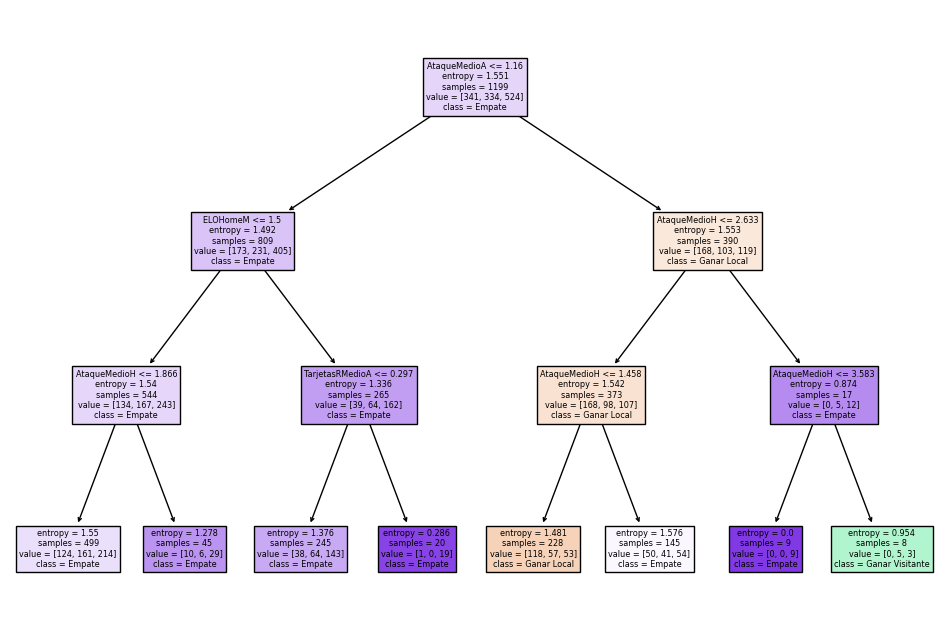

In [49]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

best_dt.fit(X_train, y_train)

plt.figure(figsize=(12, 8))
plot_tree(best_dt, feature_names=X_train.columns, class_names=['Ganar Local', 'Ganar Visitante', 'Empate'], filled=True)
plt.show()


## Random Forest

In [50]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 3, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6, 10],
}

In [51]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=3)

In [52]:
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=TimeSeriesSplit(n_splits=10),
                           scoring='accuracy', n_jobs=-1)

In [53]:
import time
# Guardar el tiempo antes de ejecutar la funcion de entrenamiento
start_time = time.time()

In [54]:
# GridSearchCV
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=RandomForestClassifier(random_state=3), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 5, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4, 6, 10],
                         'min_samples_split': [2, 5, 10, 15],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [55]:
# Guardar el tiempo despues de ejecutar la funcion de entrenamiento
end_time = time.time ()

In [56]:
# Calcular el tiempo de CPU total
cpu_time = end_time - start_time
# Mostrar e l tiempo de CPU total
print(f"El tiempo de CPU total es {cpu_time:.2f} segundos")

El tiempo de CPU total es 360.85 segundos


In [57]:
# mejor modelo
best_rf = grid_search.best_estimator_

In [58]:
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)
accuracy_train = best_rf.score(X_train, y_train)
print(f"Precisión del modelo en el conjunto de entrenamiento: {accuracy_train:.4f}")

Mejores parámetros encontrados:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Precisión del modelo en el conjunto de entrenamiento: 0.5254


In [59]:
# Realiza predicciones
y_pred = best_rf.predict(X_test)
y_pred_prob = best_rf.predict_proba(X_test)  # Probabilidades para AUC

In [60]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# AUC para cada clase y promedio ponderado
auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted')

print("Precisión del modelo en el conjunto de prueba: {:.2f}%".format(accuracy * 100))
print("Precisión (Precision) en el conjunto de prueba: {:.2f}%".format(precision * 100))
print("Recuperación (Recall) en el conjunto de prueba: {:.2f}%".format(recall * 100))
print("F1-score en el conjunto de prueba: {:.2f}%".format(f1*100))
print("AUC en el conjunto de prueba: {:.2f}%".format(auc*100))

Precisión del modelo en el conjunto de prueba: 49.00%
Precisión (Precision) en el conjunto de prueba: 39.35%
Recuperación (Recall) en el conjunto de prueba: 49.00%
F1-score en el conjunto de prueba: 42.03%
AUC en el conjunto de prueba: 60.92%


In [61]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
print(conf_matrix)

Matriz de confusión:
[[ 46   3  61]
 [ 25   1  74]
 [ 35   6 149]]


## Regresion logistica

In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix

In [63]:
param_grid = {'penalty': [None],
              'C': [1]}

In [64]:
lr_clf = LogisticRegression(max_iter=1000, random_state=3)
grid_search = GridSearchCV(estimator=lr_clf, param_grid=param_grid, cv=TimeSeriesSplit(n_splits=10),
                           scoring='accuracy', n_jobs=-1)

In [65]:
import time
# Guardar e l tiempo antes de ejecutar la funcion de entrenamiento
start_time = time.time()

In [66]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=LogisticRegression(max_iter=1000, random_state=3),
             n_jobs=-1, param_grid={'C': [1], 'penalty': [None]},
             scoring='accuracy')

In [67]:
# Guardar el tiempo despues de ejecutar la funcion de entrenamiento
end_time = time.time ()

In [68]:
# Calcular el tiempo de CPU total
cpu_time = end_time - start_time
# Mostrar e l tiempo de CPU total
print(f"El tiempo de CPU total es {cpu_time:.2f} segundos")

El tiempo de CPU total es 0.14 segundos


In [69]:
best_lr = grid_search.best_estimator_
print("Mejor parámetro C encontrado:", grid_search.best_params_)
accuracy_train = best_lr.score(X_train, y_train)
print(f"Precisión del modelo en el conjunto de entrenamiento: {accuracy_train:.4f}")

Mejor parámetro C encontrado: {'C': 1, 'penalty': None}
Precisión del modelo en el conjunto de entrenamiento: 0.4846


In [70]:
y_pred = best_lr.predict(X_test)
y_pred_prob = best_lr.predict_proba(X_test)  # Probabilidades para AUC

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# AUC para cada clase y promedio ponderado
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted')

print("Precisión del modelo en el conjunto de prueba: {:.2f}%".format(accuracy * 100))
print("Precisión (Precision) en el conjunto de prueba: {:.2f}%".format(precision * 100))
print("Recuperación (Recall) en el conjunto de prueba: {:.2f}%".format(recall * 100))
print("F1-score en el conjunto de prueba: {:.2f}%".format(f1*100))
print("AUC en el conjunto de prueba: {:.2f}%".format(auc*100))

conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
print(conf_matrix)

Precisión del modelo en el conjunto de prueba: 49.75%
Precisión (Precision) en el conjunto de prueba: 45.07%
Recuperación (Recall) en el conjunto de prueba: 49.75%
F1-score en el conjunto de prueba: 42.14%
AUC en el conjunto de prueba: 60.73%
Matriz de confusión:
[[ 45   1  64]
 [ 22   1  77]
 [ 36   1 153]]


## 5. SVM
1º kernel lineal

In [71]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

In [72]:
param_grid = {
    'C': [2**-5, 2**-4, 2**-3, 2**-2, 2**-1, 2**0, 2**1, 2**2, 2**3, 2**4, 2**5],
    'kernel': ['linear']
}

In [73]:
svm_model = SVC(random_state=3, probability=True)

In [74]:
grid_search_accur = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=TimeSeriesSplit(n_splits=4), scoring='accuracy')
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=TimeSeriesSplit(n_splits=4), scoring='accuracy')

In [75]:
import time
# Guardar e l tiempo antes de ejecutar la funcion de entrenamiento
start_time = time.time()

In [76]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=SVC(probability=True, random_state=3),
             param_grid={'C': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8,
                               16, 32],
                         'kernel': ['linear']},
             scoring='accuracy')

In [77]:
# Guardar el tiempo despues de ejecutar la funcion de entrenamiento
end_time = time.time ()

In [78]:
# Calcular el tiempo de CPU total
cpu_time = end_time - start_time
# Mostrar e l tiempo de CPU total
print(f"El tiempo de CPU total es {cpu_time:.2f} segundos")

El tiempo de CPU total es 230.79 segundos


In [79]:
print("Mejores parámetros encontrados:")
best_svm_model_lineal = grid_search.best_estimator_
print(grid_search.best_params_)
accuracy_train = best_svm_model_lineal.score(X_train, y_train)
print(f"Precisión del modelo en el conjunto de entrenamiento: {accuracy_train:.4f}")

Mejores parámetros encontrados:
{'C': 4, 'kernel': 'linear'}
Precisión del modelo en el conjunto de entrenamiento: 0.4812


In [80]:
best_svm_model_lineal = grid_search.best_estimator_
y_pred = best_svm_model_lineal.predict(X_test)
y_pred_prob = best_svm_model_lineal.predict_proba(X_test)  # Probabilidades para AUC

In [81]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# AUC para cada clase y promedio ponderado
auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted')

print("Precisión del modelo en el conjunto de prueba: {:.2f}%".format(accuracy * 100))
print("Precisión (Precision) en el conjunto de prueba: {:.2f}%".format(precision * 100))
print("Recuperación (Recall) en el conjunto de prueba: {:.2f}%".format(recall * 100))
print("F1-score en el conjunto de prueba: {:.2f}%".format(f1*100))
print("AUC en el conjunto de prueba: {:.2f}%".format(auc*100))


Accuracy: 49.75%
Precisión del modelo en el conjunto de prueba: 49.75%
Precisión (Precision) en el conjunto de prueba: 36.80%
Recuperación (Recall) en el conjunto de prueba: 49.75%
F1-score en el conjunto de prueba: 41.64%
AUC en el conjunto de prueba: 58.55%


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [82]:
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[ 45   0  65]
 [ 18   0  82]
 [ 36   0 154]]


2º kernel rbf: Gausiano

In [83]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.svm import SVC
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

Solo con accuracy

In [84]:
param_grid = {
    'C': [2**-5, 2**-4, 2**-3, 2**-2, 2**-1, 2**0, 2**1, 2**2, 2**3, 2**4, 2**5],
    'gamma': [2**-5, 2**-4, 2**-3, 2**-2, 2**-1, 2**0, 2**1, 2**2, 2**3, 2**4, 2**5],
    'kernel': ['rbf']
}

In [85]:
svm_model = SVC(probability=True)

grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=TimeSeriesSplit(n_splits=4), scoring='accuracy')

In [86]:
import time
# Guardar e l tiempo antes de ejecutar la funcion de entrenamiento
start_time = time.time()

In [87]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=SVC(probability=True),
             param_grid={'C': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8,
                               16, 32],
                         'gamma': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4,
                                   8, 16, 32],
                         'kernel': ['rbf']},
             scoring='accuracy')

In [88]:
# Guardar el tiempo despues de ejecutar la funcion de entrenamiento
end_time = time.time ()

In [89]:
# Calcular el tiempo de CPU total
cpu_time = end_time - start_time
# Mostrar e l tiempo de CPU total
print(f"El tiempo de CPU total es {cpu_time:.2f} segundos")

El tiempo de CPU total es 87.63 segundos


In [90]:
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)
accuracy_train = best_dt.score(X_train, y_train)
print(f"Precisión del modelo en el conjunto de entrenamiento: {accuracy_train:.4f}")

Mejores parámetros encontrados:
{'C': 2, 'gamma': 0.03125, 'kernel': 'rbf'}
Precisión del modelo en el conjunto de entrenamiento: 0.4929


In [91]:
best_svm_model_gau = grid_search.best_estimator_
y_pred = best_svm_model_gau.predict(X_test)
y_pred_prob = best_svm_model_gau.predict_proba(X_test)  # Probabilidades para AUC

In [92]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# AUC para cada clase y promedio ponderado
auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted')

print("Precisión del modelo en el conjunto de prueba: {:.2f}%".format(accuracy * 100))
print("Precisión (Precision) en el conjunto de prueba: {:.2f}%".format(precision * 100))
print("Recuperación (Recall) en el conjunto de prueba: {:.2f}%".format(recall * 100))
print("F1-score en el conjunto de prueba: {:.2f}%".format(f1*100))
print("AUC en el conjunto de prueba: {:.2f}%".format(auc*100))

Accuracy: 50.75%
Precisión del modelo en el conjunto de prueba: 50.75%
Precisión (Precision) en el conjunto de prueba: 46.64%
Recuperación (Recall) en el conjunto de prueba: 50.75%
F1-score en el conjunto de prueba: 45.12%
AUC en el conjunto de prueba: 58.58%


In [93]:
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[ 40   7  63]
 [ 18   8  74]
 [ 26   9 155]]


## 6. Redes Neuronales

In [94]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [95]:
param_grid = {
    'hidden_layer_sizes': [(100,), (100, 50), (50,)],
    'activation': ['logistic'],
    'solver': ['adam'],
    'max_iter': [200, 500, 1000],
}

In [96]:
# clasificador MLP
mlp_classifier = MLPClassifier()

In [97]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [98]:
# búsqueda de hiperparámetros
grid_search = GridSearchCV(mlp_classifier, param_grid, cv=TimeSeriesSplit(n_splits=10), scoring='accuracy')

import time
# Guardar el tiempo antes de ejecutar la funcion de entrenamiento
start_time = time.time()

grid_search.fit(X_train_scaled, y_train)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_mult

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=MLPClassifier(),
             param_grid={'activation': ['logistic'],
                         'hidden_layer_sizes': [(100,), (100, 50), (50,)],
                         'max_iter': [200, 500, 1000], 'solver': ['adam']},
             scoring='accuracy')

In [99]:
# Guardar el tiempo despues de ejecutar la funcion de entrenamiento
end_time = time.time ()

In [100]:
# Calcular el tiempo de CPU total
cpu_time = end_time - start_time
# Mostrar e l tiempo de CPU total
print(f"El tiempo de CPU total es {cpu_time:.2f} segundos")

El tiempo de CPU total es 19.53 segundos


In [101]:
print("Mejores parámetros:", grid_search.best_params_)

Mejores parámetros: {'activation': 'logistic', 'hidden_layer_sizes': (50,), 'max_iter': 200, 'solver': 'adam'}


In [102]:
# Entrena el modelo con los mejores parámetros encontrados
best_mlp_classifier = grid_search.best_estimator_
best_mlp_classifier.fit(X_train_scaled, y_train)

MLPClassifier(activation='logistic', hidden_layer_sizes=(50,))

In [103]:
# Realiza predicciones
y_pred = best_mlp_classifier.predict(X_test_scaled)
y_pred_prob = best_mlp_classifier.predict_proba(X_test_scaled)[:, 1]  # Probabilidades para AUC

In [104]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Realiza predicciones
y_pred = best_mlp_classifier.predict(X_test_scaled)
y_pred_prob = best_mlp_classifier.predict_proba(X_test_scaled)  # Probabilidades para AUC

# Calcula varias métricas para problemas multiclase
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# AUC para cada clase y promedio ponderado
auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted')

print("Precisión del modelo: {:.2f}%".format(accuracy * 100))
print("Precisión (Precision): {:.2f}%".format(precision * 100))
print("Recuperación (Recall): {:.2f}%".format(recall * 100))
print("F1-score: {:.2f}%".format(f1 * 100))
print("AUC: {:.2f}%".format(auc * 100))

Precisión del modelo: 49.50%
Precisión (Precision): 49.01%
Recuperación (Recall): 49.50%
F1-score: 42.04%
AUC: 61.27%


## TSVM


In [105]:
import pandas as pd

# Cargar el archivo Excel en un DataFrame de pandas
datos = pd.read_excel('datos_tsvm.xlsx')

print(datos.head())

    Season       Date    HomeTeam     AwayTeam  PartidoSeason  ELOHomeT  \
0  2019-20 2019-08-16  Ath Bilbao    Barcelona              1         0   
1  2019-20 2019-08-17       Celta  Real Madrid              1         0   
2  2019-20 2019-08-17    Valencia     Sociedad              1         0   
3  2019-20 2019-08-17    Mallorca        Eibar              1         0   
4  2019-20 2019-08-17     Leganes      Osasuna              1         0   

   ELOHomeM  ELOAwayT  ELOAwayM  AtaqueMedioH  AtaqueMedioA  TarjetasRMedioH  \
0         0         0         0           0.0           0.0              0.0   
1         0         0         0           0.0           0.0              0.0   
2         0         0         0           0.0           0.0              0.0   
3         0         0         0           0.0           0.0              0.0   
4         0         0         0           0.0           0.0              0.0   

   TarjetasRMedioA Resultado  
0              0.0         H  
1     

In [106]:
valores_faltantes = data.isnull().sum()
valores_faltantes_porcentaje = 100*valores_faltantes/len(data)

valores_faltantes_df = pd.DataFrame({'count': valores_faltantes, 'percent': valores_faltantes_porcentaje})
valores_faltantes_df.sort_values('percent', ascending=False)

,count,percent
Season,0,0.0
Date,0,0.0
HomeTeam,0,0.0
AwayTeam,0,0.0
PartidoSeason,0,0.0
ELOHomeT,0,0.0
ELOHomeM,0,0.0
ELOAwayT,0,0.0
ELOAwayM,0,0.0
AtaqueMedioH,0,0.0


In [107]:
# Codificar la variable respuesta
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['Resultado'] = label_encoder.fit_transform(datos['Resultado'])

In [108]:
X = datos.drop(['PartidoSeason','Resultado', 'Date', 'Season', 'HomeTeam', 'AwayTeam'], axis=1)
y = datos['Resultado']

In [109]:
from sklearn.model_selection import train_test_split

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.25, shuffle=False) #importa no hacerlo de manera aleatoria

In [110]:
# Modelo
model_tsvm = TwinSVMClassifier()

param_grid_tsvm_radial = {
    'Epsilon1': [0.1],
    'Epsilon2': [0.1],
    'C1':[2**(-5),2**(-3),2**(-1),2**(1),2**(3),2**(5)],
    'C2':[2**(-5),2**(-3),2**(-1),2**(1),2**(3),2**(5)],
    'kernel_type': [3], # 1 lineal, 2 polinomial, 3 radial
    'kernel_param': [2**(-5),2**(-3),2**(-1),2**(1),2**(3),2**(5)],
}

NameError: name 'TwinSVMClassifier' is not defined

In [ ]:
keys, values = zip(*param_grid_tsvm_radial.items())

In [ ]:
# Generar todas las combinaciones de valores de parámetros
combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]

In [ ]:
# Búsqueda de hiperparámetros con validación cruzada estratificada
stratified_cv = TimeSeriesSplit(n_splits=5)
best_auc = 0

In [ ]:
for params_sel in combinations:
    print(params_sel)
    auc_folds = []
    for train_index, test_index in stratified_cv.split(X_train_1, y_train_1):
        X_train_inner = X_train_1.iloc[train_index]
        X_test_inner = X_train_1.iloc[test_index]
        y_train_inner = y_train_1.iloc[train_index]
        y_test_inner = y_train_1.iloc[test_index]

        # Asegúrate de que los datos están en el formato correcto
        X_train_inner = X_train_inner.to_numpy()
        X_test_inner = X_test_inner.to_numpy()
        y_train_inner = y_train_inner.to_numpy()
        y_test_inner = y_test_inner.to_numpy()

        # Inicializar el modelo con los parámetros seleccionados
        twin_svm = TwinSVMClassifier(**params_sel)

        # Entrenar el modelo
        twin_svm.fit(X_train_inner, y_train_inner)

        # Hacer predicciones
        y_pred_prob = twin_svm.decision_function(X_test_inner)

        # Calcular métricas de evaluación
        auc = roc_auc_score(y_test_inner, y_pred_prob)
        auc_folds.append(auc)

    mean_auc = sum(auc_folds) / len(auc_folds)
    if mean_auc > best_auc:
        best_auc = mean_auc
        best_params = params_sel

# Estrategia de apuestas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

nuevos_datos = pd.read_excel('datos_parte2.xlsx')
cuotas = pd.read_excel('cuotas.xlsx')

label_encoder = LabelEncoder()
nuevos_datos['Resultado'] = label_encoder.fit_transform(nuevos_datos['Resultado'])

train_df_nuevo = nuevos_datos[(nuevos_datos['Season'] >= '2019-20') & (nuevos_datos['Season'] <= '2022-23')]
test_df_nuevo = nuevos_datos[nuevos_datos['Season'] == '2023-24']

X_train_2 = train_df_nuevo.drop(columns=['Semana', 'Resultado', 'Date', 'Season', 'HomeTeam', 'AwayTeam'])
y_train_2 = train_df_nuevo['Resultado']
X_test_2 = test_df_nuevo.drop(columns=['Semana', 'Resultado', 'Date', 'Season', 'HomeTeam', 'AwayTeam'])
y_test_2 = test_df_nuevo['Resultado']


In [ ]:
best_lr.fit(X_train_2, y_train_2)

y_pred_prob_2 = best_lr.predict_proba(X_test_2)
y_pred_class_2 = best_lr.predict(X_test_2)

In [ ]:
equipo = "Sociedad"

test_df_equipo = test_df_nuevo[(test_df_nuevo['HomeTeam'] == equipo) | (test_df_nuevo['AwayTeam'] == equipo)]

X_test_equipo = test_df_equipo.drop(columns=['Semana', 'Resultado', 'Date', 'Season', 'HomeTeam', 'AwayTeam'])
y_test_equipo = test_df_equipo['Resultado']

In [ ]:
# Predecir probabilidades y clases para el equipo
y_pred_prob_equipo = best_lr.predict_proba(X_test_equipo)
y_pred_class_equipo = best_lr.predict(X_test_equipo)

resultados_equipo = test_df_equipo[['Date', 'HomeTeam', 'AwayTeam', 'Resultado']].copy()
resultados_equipo['Probabilidades'] = y_pred_prob_equipo.tolist()
resultados_equipo['Prediccion'] = y_pred_class_equipo

In [ ]:
resultados_equipo = resultados_equipo.merge(cuotas, on=['Date', 'HomeTeam', 'AwayTeam'], how='left')

In [ ]:
# Fracción de Kelly 
def calcular_fraccion_kelly(probabilidades, cuota):
    p = probabilidades
    b = cuota - 1
    return max(0, (b * p - (1 - p)) / b)

resultados_equipo['Fraccion_Kelly_Local'] = resultados_equipo.apply(
    lambda row: calcular_fraccion_kelly(row['Probabilidades'][0], row['cuota local']), axis=1)
resultados_equipo['Fraccion_Kelly_Visitante'] = resultados_equipo.apply(
    lambda row: calcular_fraccion_kelly(row['Probabilidades'][2], row['cuota visitante']), axis=1)
resultados_equipo['Fraccion_Kelly_Empate'] = resultados_equipo.apply(
    lambda row: calcular_fraccion_kelly(row['Probabilidades'][1], row['cuota empate']), axis=1)

In [ ]:
# fracción de Kelly mitad del valor original
resultados_equipo['Fraccion_Kelly_Local'] /= 2
resultados_equipo['Fraccion_Kelly_Visitante'] /= 2
resultados_equipo['Fraccion_Kelly_Empate'] /= 2

resultados_equipo = resultados_equipo.sort_values(by='Date')

In [ ]:
bankroll = 1000
resultados_equipo['Bankroll'] = bankroll

resultados_equipo['Bankroll'] = resultados_equipo['Bankroll'].astype(float)

ROI = [bankroll]

for index, row in resultados_equipo.iterrows():
    fraccion_local = row['Fraccion_Kelly_Local']
    fraccion_visitante = row['Fraccion_Kelly_Visitante']
    fraccion_empate = row['Fraccion_Kelly_Empate']

    if row['Resultado'] == 0:  # Gana equipo local
        if row['Prediccion'] == 0:
            bankroll += fraccion_local * (row['cuota local'] - 1) * bankroll
        else:
            bankroll -= fraccion_local * bankroll
    elif row['Resultado'] == 2:  # Gana equipo visitante
        if row['Prediccion'] == 2:
            bankroll += fraccion_visitante * (row['cuota visitante'] - 1) * bankroll
        else:
            bankroll -= fraccion_visitante * bankroll
    elif row['Resultado'] == 1:  # Empate
        if row['Prediccion'] == 1:
            bankroll += fraccion_empate * (row['cuota empate'] - 1) * bankroll
        else:
            bankroll -= fraccion_empate * bankroll
    
    ROI.append(bankroll)
    resultados_equipo.at[index, 'Bankroll'] = bankroll

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(resultados_equipo['Date'], resultados_equipo['Bankroll'], marker='o')
plt.title('Evolución del Bankroll a lo largo de la temporada')
plt.xlabel('Fecha')
plt.ylabel('Bankroll (€)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


tabla_resumida = resultados_equipo[['Date', 'HomeTeam', 'AwayTeam', 'Fraccion_Kelly_Local', 'Fraccion_Kelly_Visitante', 'Fraccion_Kelly_Empate', 'Bankroll']]
print(tabla_resumida)
